The Ising model is a simple model for a magnet. It consists of $N$ spins, which are variables $\sigma_1, \sigma_2, \dots, \sigma_N$. Each spin (for example $\sigma_i$) takes values in $\{-1, +1\}$. A configuration is specified by giving the value of every spin; we denote such a configuration by $\sigma = (\sigma_1, \sigma_2, \dots, \sigma_N)$.

To each configuration $\sigma$ we associate an energy $E(\sigma)$ which for the one-dimensional model is
\begin{equation}
    E(\sigma) = -J \left[ \sigma_N \sigma_1 + \sum_{i=1}^{N-1} \sigma_i\sigma{i+1} \right] - h\sum_{i=1}^N \sigma_i.
\end{equation}
The first term in the square brackets is present because we have arranged the spins on a circle so the $N$-th spin is adjacent to the first one (periodic boundary conditions). In the canonical ensemble at temperature $T$, configuration $\sigma$ occurs with a probability given by the Boltzmann distribution
\begin{equation}
    p(\sigma | T) = \frac{1}{Z} \exp\left(-\frac{E(\sigma)}{T}\right)
\end{equation}
where $Z$ is the partition function (normalisation constant).

A common aim in statistical mechanics is to compute averages of observable quantities with respect to $p$. For example we might compute the average energy $U(T) = \sum_\sigma E(\sigma)p(\sigma|T)$, where the sum runs over all possible configurations. For the one dimensional Ising model this sum can be done analytically. In two dimensions, the average energy can be computed analytically for the special case $h = 0$, but not otherwise. In three dimensions, the average energy cannot be computed analytically.

We consider a general numerical method for computing averages in the canonical
ensemble. In principle this method can be used in any dimension, here we consider $d = 1$. The idea is to define a dynamical process by which the Ising model evolves, as a function of time. This process is random. Within its steady state, configuration $\sigma$ appears with probability $p(\sigma|T)$. Hence one can use the random process to estimate averages such as $U(T)$. This method is very useful in systems that cannot be solved analytically. It is related to Markov chain Monte Carlo (MCMC) methods in statistics.

---

The magnetisation of a configuration is
\begin{equation}
    \hat{M}(\sigma) = \frac{1}{N} \sum_i \sigma_i.
\end{equation}
Its average with respect to the Boltzmann distribution is
\begin{equation}
    M(T) = \sum_\sigma \hat{M} (\sigma)p(\sigma|T)
\end{equation}
where the sum runs over all configurations. Note that $M(T)$ depends on $J$, $h$, $N$ as well as $T$. The (scaled) magnetic susceptibility is $\chi(T) = T \frac{\partial M}{\partial h}$. This quantity is related to the variance of $\hat{M}$ , as
\begin{equation}
    \chi(T) = N\sum_\sigma [\hat{M}(\sigma) - M(T)]^2 p(\sigma|T).
\end{equation}
In the limit $N \to \infty$, it can be shown by transfer matrix methods that
\begin{equation}
    M(T) = \sinh(h/T) \frac{\cosh(h/T) + \sqrt{\sinh^2(h/T) + e^{-4J/T}}}{\sinh^2(h/T) + e^{-4J/T} + \cosh(h/T)\sqrt{\sinh^2(h/T) + e^{-4J/T}}}.
\end{equation}
For $h = 0$ we have also
\begin{equation}
    \chi(T) = e^{2J/T}.
\end{equation}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def theoretical_magnetisation(J, h, beta):
    X = beta * h
    Y = np.exp(-4 * J * beta)

    sinh_X = np.sinh(X)
    cosh_X = np.cosh(X)
    sinh2_X = sinh_X**2

    R = np.sqrt(sinh2_X + Y)

    numerator = cosh_X + R
    denominator = sinh2_X + Y + cosh_X * R

    M_theoretical = sinh_X * (numerator / denominator)
    return M_theoretical

def theoretical_susceptibility(J, beta):
    return np.exp(2 * J * beta)

We will use a computer to generate a sequence of configurations, which correspond to the Ising model evolving (stochastically) as a function of time. The time $t$ is a positive integer and the $t$-th configuration is denoted by $\sigma(t)$.

To generate the configuration $\sigma(t + 1)$, first set $\sigma(t + 1) = \sigma(t)$; then choose a random integer $i$ between $1$ and $N$; and finally replace $\sigma_i(t + 1) $by either $-1$ or $1$, according to
\begin{align}
    \Pr[\sigma_i(t + 1) = +1] &= \frac{1}{1 + e^{-2\kappa_i/T}}, \\
    \Pr[\sigma_i(t + 1) = -1] &= \frac{1}{1 + e^{2\kappa_i/T}},
\end{align}
with
\begin{equation}
    \kappa_i = h + J(\sigma_{i+1} + \sigma_{i-1}).
\end{equation}
This update yields the new configuration $\sigma(t + 1)$, which may be identical to $\sigma(t)$, or it may differ in exactly one spin. It is easy to verify that the probabilities of the two possible values of $\sigma_i(t+1)$ sum to unity. In the formula for $\kappa_i$ then $\sigma_{N+1}$ should be interpreted as $\sigma1$ and $\sigma_0$ should be interpreted as $\sigma_N$, to take care of the periodic boundaries. The variable $\kappa_i$ is sometimes
called the local field. We can check that the difference in energy between configurations with $\sigma_i = -1$ and $\sigma_i = 1$ is $2\kappa_i$.

After many updates, the probability that the system ends in configuration $\sigma$ converges to $p(\sigma|T)$. It is useful to define a rescaled time $\tau = t/N$. If $\tau = 1$, then this means that $N$ updates have been performed.

---

We will write a program that stores a configuration of $N$ Ising spins, and performs random updates using the rule described above. The configuration should be stored as a sequence of $1$'s and $-1$'s in an array of size $N$. We can verify that while the parameters $J$, $h$, $T$ all appear in the algorithm, the behaviour of the system only depends on $J/T$ and $h/T$. These parameters will have the same value for every update (they are independent of time). In order to do the updates, we will need to generate random numbers.

Here is an outline of the program that we will write. It depends on a few parameters whose values will be discussed later:

1.  Choose an initial condition with $\sigma_i = 1$ for all $i$.

2.  Define a parameter $n_w$ and perform $n_w \times N$ updates to warm up the system. The initial configuration was our choice, but the idea is that if $n_w$ is reasonably large then the final configuration will be distributed approximately as $p(\sigma|T)$. After this warming up, the rescaled time is $\tau = n_w$. Set a counter $k = 1$ and define a parameter $K$.

3.  For the configuration obtained at the current time $t$, compute and store the magnetisation as
\begin{equation}
    M_k = \frac{1}{N} \sum_i \sigma_i(t).
\end{equation}

4.  Continue updating for an additional rescaled time $n_I$, that is, perform $n_I \times N$ updates. Increase the counter $k$ by $1$.

5.  Repeat steps 3 and 4 until $k = K$. At the end of this procedure, we will have stored a list of $K$ values of the magnetisation, which are $M_1, M_2, \dots, M_K$. We store these in an array of size $K$.

6.  Compute the average of the magnetisation values, and also a scaled measure of their variance, as
\begin{align}
    \bar{M} = \frac{1}{K} \sum_{k=1}^K M_k, \\
    \hat\chi = \frac{N}{K} \sum_{k=1}^K (M_k - M)^2.
\end{align}

The algorithm is designed in such a way that if $K$ and $n_w$ are large enough, then we expect $\bar{M}$ and $\hat\chi$ to be close to the equilibrium magnetisation $M(T)$ and susceptibility $\chi(T)$, as defined above.

In [ ]:
def run_ising_simulation(N, J, h, beta, n_w, n_I, K):
    '''
    Simulates the 1D Ising Model.
    Parameters:
    N   : Number of spins
    J   : Coupling constant
    h   : External magnetic field
    beta : Inverse temperature 1/T
    n_w : Warm-up parameter (rescaled time)
    n_I : Interval parameter between measurements (rescaled time)
    K   : Number of measurement samples
    Returns:
    M_bar   : Average magnetisation
    chi_hat : Scaled magnetic susceptibility
    '''
    # Initialise spins as 1
    spins = np.ones(N, dtype=int)
    current_total_M = N  # sum of all spins (initially N * 1)

    # Precompute probabilities, index = (sum + 2) // 2
    neighbor_sums = [-2, 0, 2] # The sum of neighbors can only be: -2, 0, or +2.
    # Store P(sigma_i = +1) based on neighbor sum
    prob_lookup = np.zeros(3)

    for idx, s in enumerate(neighbor_sums):
        kappa = h + J * s
        prob_lookup[idx] = 1.0 / (1.0 + np.exp(-2.0 * kappa * beta))

    # Generate random numbers in batches
    BUFFER_SIZE = 100000
    rand_indices = np.random.randint(0, N, size=BUFFER_SIZE)
    rand_floats = np.random.rand(BUFFER_SIZE)
    buffer_cursor = 0

    def refresh_buffer():
        nonlocal rand_indices, rand_floats, buffer_cursor
        rand_indices = np.random.randint(0, N, size=BUFFER_SIZE)
        rand_floats = np.random.rand(BUFFER_SIZE)
        buffer_cursor = 0

    # Warm-up phase
    warmup_steps = int(n_w * N)

    for _ in range(warmup_steps):
        # Refill random buffer if needed
        if buffer_cursor >= BUFFER_SIZE:
            refresh_buffer()

        # Get random spin index and random probability check
        i = rand_indices[buffer_cursor]
        r = rand_floats[buffer_cursor]
        buffer_cursor += 1

        # Periodic boundary conditions
        left = spins[i-1]
        right = spins[(i+1) % N]

        # Look up probability
        n_sum = left + right
        p_idx = (n_sum + 2) // 2
        prob_plus = prob_lookup[p_idx]

        # Update spin
        old_spin = spins[i]
        new_spin = 1 if r < prob_plus else -1

        if new_spin != old_spin:
            spins[i] = new_spin
            current_total_M += 2 * new_spin # Update total M incrementally

    # Measurement phase
    M_values = np.zeros(K)
    steps_between = int(n_I * N)

    for k in range(K):
        # Store current normalised M
        M_values[k] = current_total_M / N

        # Evolve for interval n_I
        for _ in range(steps_between):
            if buffer_cursor >= BUFFER_SIZE:
                refresh_buffer()

            i = rand_indices[buffer_cursor]
            r = rand_floats[buffer_cursor]
            buffer_cursor += 1

            left = spins[i-1]
            right = spins[(i+1) % N]

            n_sum = left + right
            p_idx = (n_sum + 2) // 2
            prob_plus = prob_lookup[p_idx]

            old_spin = spins[i]
            new_spin = 1 if r < prob_plus else -1

            if new_spin != old_spin:
                spins[i] = new_spin
                current_total_M += 2 * new_spin

    # Compute statistics
    M_bar = np.mean(M_values)
    chi_hat = (N / K) * np.sum((M_values - M_bar)**2)

    return M_bar, chi_hat

In [ ]:
# Parameters
N = 50
n_w = 10000
n_I = 5
K = 2048

J = 1.0
h = 0.1

beta_values = np.linspace(0.0, 2.5, 6)
num_repeats = 5

sim_M_means = []
sim_M_stds  = []
sim_Chi_means = []
sim_Chi_stds  = []

print(f"Parameters: N={N}, J={J}, h={h}, Repeats per beta={num_repeats}")
print("-" * 60)
print(f"{'Beta':<10} | {'M_bar (Mean)':<15} | {'M_bar (Std)':<15} | {'Theory M':<15}")
print("-" * 60)

for beta in beta_values:
    m_runs = []
    chi_runs = []

    for r in range(num_repeats):
        m_val, chi_val = run_ising_simulation(N, J, h, beta, n_w, n_I, K)
        m_runs.append(m_val)
        chi_runs.append(chi_val)

    m_mean = np.mean(m_runs)
    m_std  = np.std(m_runs)
    chi_mean = np.mean(chi_runs)
    chi_std  = np.std(chi_runs)

    sim_M_means.append(m_mean)
    sim_M_stds.append(m_std)
    sim_Chi_means.append(chi_mean)
    sim_Chi_stds.append(chi_std)

    theory_val = theoretical_magnetisation(J, h, beta)

    print(f"{beta:<10.2f} | {m_mean:<15.4f} | {m_std:<15.4f} | {theory_val:<15.4f}")

sim_M_means = np.array(sim_M_means)
sim_M_stds  = np.array(sim_M_stds)
sim_Chi_means = np.array(sim_Chi_means)
sim_Chi_stds  = np.array(sim_Chi_stds)

beta_smooth = np.linspace(0, 2.5, 200)
M_theory_smooth = theoretical_magnetisation(J, h, beta_smooth)

Parameters: N=50, J=1.0, h=0.1, Repeats per beta=5
------------------------------------------------------------
Beta       | M_bar (Mean)    | M_bar (Std)     | Theory M       
------------------------------------------------------------
0.00       | -0.0001         | 0.0025          | 0.0000         
0.50       | 0.1316          | 0.0054          | 0.1347         
1.00       | 0.5989          | 0.0191          | 0.5949         
1.50       | 0.9499          | 0.0057          | 0.9494         
2.00       | 0.9966          | 0.0010          | 0.9959         
2.50       | 0.9997          | 0.0002          | 0.9996         


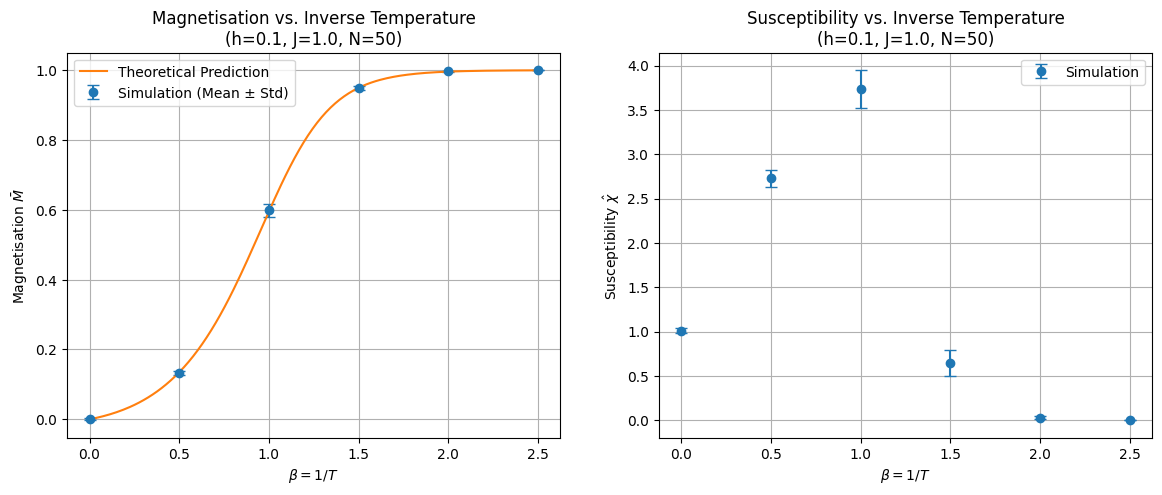

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.errorbar(beta_values, sim_M_means, yerr=sim_M_stds, fmt='o', capsize=4, label='Simulation (Mean ± Std)')
plt.plot(beta_smooth, M_theory_smooth, label='Theoretical Prediction')
plt.xlabel(r'$\beta = 1/T$')
plt.ylabel(r'Magnetisation $\bar{M}$')
plt.title(f'Magnetisation vs. Inverse Temperature\n(h={h}, J={J}, N={N})')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.errorbar(beta_values, sim_Chi_means, yerr=sim_Chi_stds, fmt='o', capsize=4, label='Simulation')
plt.xlabel(r'$\beta = 1/T$')
plt.ylabel(r'Susceptibility $\hat{\chi}$')
plt.title(f'Susceptibility vs. Inverse Temperature\n(h={h}, J={J}, N={N})')
plt.grid(True)
plt.legend()

plt.show()

We observe that the plot for the analytical solution closely follows the numerical solution derived from the transfer matrix method. As $\beta$ increases (temperature decreases), the magnetisation increases towards $1$ and all spins become aligned.

The Ising model update step uses random numbers, Therefore, two simulations with the same parameters will traverse the phase space differently. By running the simulation multiple times for each $\beta$, we can calculate the standard deviation of the results.
    
The error bars fluctuations are larger in the region where the susceptibility $\chi$ is high. This is typical for statistical systems near transition points or where thermal fluctuations are significant. At very high $\beta$ (low $T$), the system freezes into the ground state, and variance drops to zero. At $\beta=0$ ($T \to \infty$), the system is purely random, and variance is governed by statistical noise $1/\sqrt{K}$.

In [ ]:
# Parameters
N = 50
n_w = 10000
n_I = 5
K = 2048

J = 1.0
h = 0.0

beta_values = np.linspace(0.0, 2.5, 6)
num_repeats = 10

sim_M_means = []
sim_M_stds = []
sim_Chi_means = []
sim_Chi_stds = []

print(f"{'Beta':<10} | {'M Mean':<10} | {'M Std':<10} | {'Chi Mean':<10} | {'Chi Std':<10} | {'Theory Chi':<10}")
print("-" * 75)

for beta in beta_values:
    m_runs = []
    chi_runs = []

    for r in range(num_repeats):
        m, chi = run_ising_simulation(N, J, h, beta, n_w, n_I, K)
        m_runs.append(m)
        chi_runs.append(chi)

    m_mean = np.mean(m_runs)
    m_std  = np.std(m_runs)
    chi_mean = np.mean(chi_runs)
    chi_std  = np.std(chi_runs)

    sim_M_means.append(m_mean)
    sim_M_stds.append(m_std)
    sim_Chi_means.append(chi_mean)
    sim_Chi_stds.append(chi_std)

    theory_val = theoretical_susceptibility(J, beta)

    print(f"{beta:<10.2f} | {m_mean:<10.4f} | {m_std:<10.4f} | {chi_mean:<10.4f} | {chi_std:<10.4f} | {theory_val:<10.4f}")

sim_M_means = np.array(sim_M_means)
sim_M_stds  = np.array(sim_M_stds)
sim_Chi_means = np.array(sim_Chi_means)
sim_Chi_stds  = np.array(sim_Chi_stds)

beta_smooth = np.linspace(0, 2.5, 200)
M_theory = np.zeros_like(beta_smooth) # M is theoretically 0 for h=0
chi_theory = theoretical_susceptibility(J, beta_smooth)

Beta       | M Mean     | M Std      | Chi Mean   | Chi Std    | Theory Chi
---------------------------------------------------------------------------
0.00       | -0.0019    | 0.0024     | 1.0038     | 0.0295     | 1.0000    
0.50       | 0.0012     | 0.0047     | 2.6884     | 0.0755     | 2.7183    
1.00       | 0.0105     | 0.0245     | 7.2459     | 0.2455     | 7.3891    
1.50       | 0.0483     | 0.0388     | 19.0929    | 2.1016     | 20.0855   
2.00       | 0.0872     | 0.4044     | 30.8787    | 4.8530     | 54.5982   
2.50       | 0.3567     | 0.8846     | 2.4436     | 4.5685     | 148.4132  


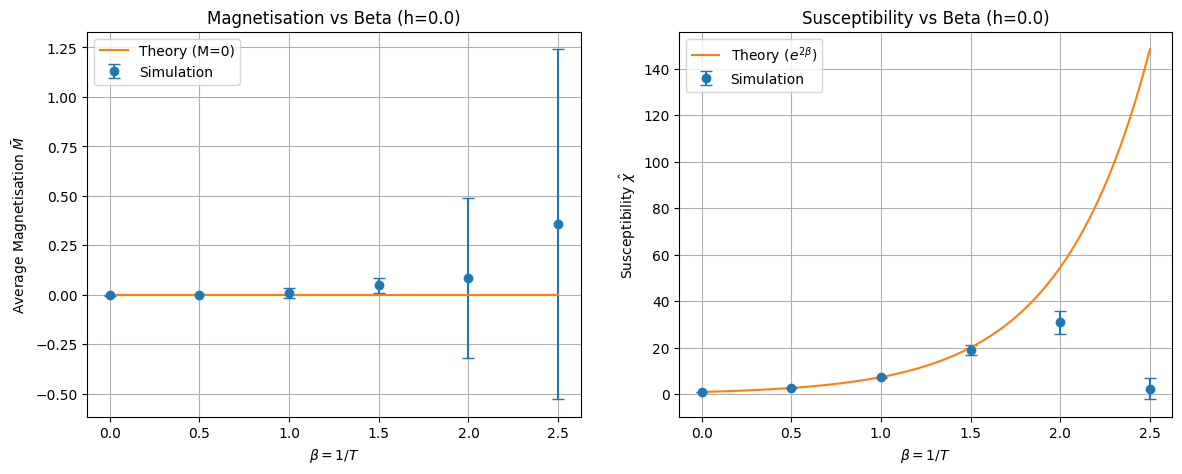

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.errorbar(beta_values, sim_M_means, yerr=sim_M_stds, fmt='o', capsize=4, label='Simulation')
plt.plot(beta_smooth, M_theory, label='Theory (M=0)')
plt.xlabel(r'$\beta = 1/T$')
plt.ylabel(r'Average Magnetisation $\bar{M}$')
plt.title(f'Magnetisation vs Beta (h={h})')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(beta_values, sim_Chi_means, yerr=sim_Chi_stds, fmt='o', capsize=4, label='Simulation')
plt.plot(beta_smooth, chi_theory, label=r'Theory ($e^{2\beta}$)')
plt.xlabel(r'$\beta = 1/T$')
plt.ylabel(r'Susceptibility $\hat{\chi}$')
plt.title(f'Susceptibility vs Beta (h={h})')
plt.grid(True)
plt.legend()

plt.show()

Theoretically, for $h=0$, the average magnetisation is 0 (positive and negative states are equally likely). However, we see that at high $\beta$ (low temperature), the simulation does not average to zero. Since we start with all spins at $1$, and the system becomes non-ergodic at low temperatures, it often gets trapped in the $1$ state for the entire simulation. The standard deviation become huge as evidenced by the large error bars/

At low $\beta$ (high $T$), the simulation matches the theory $\chi = e^{2\beta}$. However, at high $\beta$, the simulation often fails to capture the true magnitude of fluctuations because the system is stuck in a single ground state. We see the numerical susceptibility drop at high $\beta$, diverging from the exponential theoretical curve.
